# **Chapter 7**

## **61.운송 최적화 문제를 풀어보자**

최적화 계산 라이브러리를 사용하여 운송 최적화 문제를 다루게 될 것!
* `pulp`
* `ortoolpy`

In [ ]:
!pip install pulp ortoolpy

In [ ]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

In [ ]:
df_tc = pd.read_csv('trans_cost.csv', index_col='공장')
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

In [ ]:
df_tc.head()

,F1,F2,F3,F4
공장,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


In [ ]:
df_tc.index

Index(['W1', 'W2', 'W3'], dtype='object', name='공장')

In [ ]:
df_tc.columns

Index(['F1', 'F2', 'F3', 'F4'], dtype='object')

In [ ]:
df_demand.head()

,F1,F2,F3,F4
0,28,29,31,25


In [ ]:
df_supply.head()

,W1,W2,W3
0,35,41,42


In [ ]:
# 초기 설정
np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))

In [ ]:
pr

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3)]

In [ ]:
# 수리 모델 작성

m1 = model_min()

v1 = {(i,j): LpVariable('v%d_%d'%(i,j), lowBound=0) for i,j in pr}
m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)
# 제약 조건 정의
for i in range(nw):
  m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf):
  m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]
# 최적화 문제 해결
m1.solve()

# 총 운송 비용 계산
df_tr_sol = df_tc.copy()
print(df_tr_sol)
total_cost=0
for k,x in v1.items():
  i,j = k[0],k[1]
  df_tr_sol.iloc[i][j] = value(x)
  total_cost += df_tc.iloc[i][j]*value(x)

print(df_tr_sol)
print('총 운송 비용: ' + str(total_cost) + '만원')

    F1  F2  F3  F4
공장                
W1  10  10  11  27
W2  18  21  12  14
W3  15  12  14  12
    F1  F2  F3  F4
공장                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
총 운송 비용: 1296.0만원


In [ ]:
m1

NoName:
MINIMIZE
10*v0_0 + 10*v0_1 + 11*v0_2 + 27*v0_3 + 18*v1_0 + 21*v1_1 + 12*v1_2 + 14*v1_3 + 15*v2_0 + 12*v2_1 + 14*v2_2 + 12*v2_3 + 0
SUBJECT TO
_C1: v0_0 + v0_1 + v0_2 + v0_3 <= 35

_C2: v1_0 + v1_1 + v1_2 + v1_3 <= 41

_C3: v2_0 + v2_1 + v2_2 + v2_3 <= 42

_C4: v0_0 + v1_0 + v2_0 >= 28

_C5: v0_1 + v1_1 + v2_1 >= 29

_C6: v0_2 + v1_2 + v2_2 >= 31

_C7: v0_3 + v1_3 + v2_3 >= 25

VARIABLES
v0_0 Continuous
v0_1 Continuous
v0_2 Continuous
v0_3 Continuous
v1_0 Continuous
v1_1 Continuous
v1_2 Continuous
v1_3 Continuous
v2_0 Continuous
v2_1 Continuous
v2_2 Continuous
v2_3 Continuous


**목적함수를 제약 조건 하에서 "최소화"할 수 있다.**

*   `m1` 최소화를 진행하는 모델
*   변수 `v1`은 `LpVariable`을 사용하여 `dict` 형식으로 정의한다.
*   `m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)` 목적함수 `m1`을 `lpSum`을 이용하여 정의
  * 각 운송 경로의 비용을 저장한 `df_tc`와 주요 변수 `v1`과의 각 요소의 곱의 합으로 목적함수 정의.
*   제약조건도 `lpSum`을 이용하여 정의 가능
*   `solve()`를 통해 변수 `v1`이 최적화되고 최적의 총 운송 비용이 구해진다.



In [ ]:
from pulp import LpStatus
LpStatus[m1.status]

'Optimal'

최적화 상태:
*   `Optimal`: 최적의 해를 찾음
*   `Infeasible`: 문제의 제약 조건을 만족하는 해가 존재하지 않음
*   `Unbounded`: 목적 함수의 값이 무한대로 증가할 수 있음(제약 부족)




## **62. 최적 운송 경로를 네트워크로 확인하자**

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

df_tr = df_tr_sol.copy()
print(df_tr)
df_pos = pd.read_csv('trans_route_pos.csv')

    F1  F2  F3  F4
공장                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20


In [ ]:
df_pos

,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


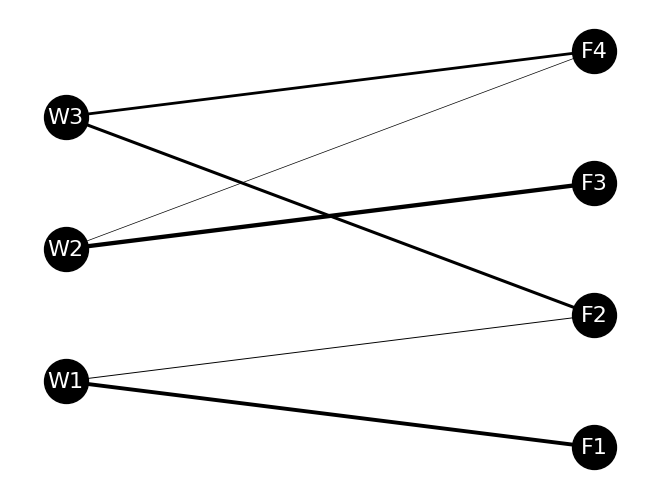

In [ ]:
# 객체 생성
G = nx.Graph()

# 노드 설정
for i in range(len(df_pos.columns)):
  G.add_node(df_pos.columns[i])

# 엣지 설정 및 엣지의 가중치 리스트화
num_pre=0
edge_weights=[]
size=0.1

for i in range(len(df_pos.columns)):
  for j in range(len(df_pos.columns)):
    if not (i==j):
      G.add_edge(df_pos.columns[i], df_pos.columns[j])
      # 엣지 가중치 추가
      if num_pre < len(G.edges):
        num_pre = len(G.edges)
        weight=0
        if (df_pos.columns[i] in df_tr.columns) and (df_pos.columns[j] in df_tr.index):
          if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
            weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
        elif (df_pos.columns[j] in df_tr.columns) and (df_pos.columns[i] in df_tr.index):
            if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
              weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
        edge_weights.append(weight)

# 좌표 설정
pos={}
for i in range(len(df_pos.columns)):
  node = df_pos.columns[i]
  pos[node]=(df_pos[node][0], df_pos[node][1])

# 그리기
nx.draw(G, pos, with_labels=True, font_size=16, node_size=1000, node_color='k', font_color='w', width=edge_weights)

# 표시
plt.show()

운송 경로는 어느 정도 집중돼야 한다.

## **63. 최적 운송 경로가 제약 조건을 만족하는지 확인하자**

In [ ]:
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

In [ ]:
# 제약 조건 계산 함수

# 수요측
def condition_demand(df_tr, df_demand):
  flag = np.zeros(len(df_demand.columns))
  for i in range(len(df_demand.columns)):
    temp_sum = sum(df_tr[df_demand.columns[i]])
    if (temp_sum >= df_demand.iloc[0][i]):
      flag[i]=1
  return flag

# 공급측
def condition_supply(df_tr, df_supply):
  flag = np.zeros(len(df_supply.columns))
  for i in range(len(df_supply.columns)):
    temp_sum = sum(df_tr.loc[df_supply.columns[i]])
    if temp_sum <= df_supply.iloc[0][i]:
      flag[i]=1
  return flag

print('수요 조건 계산 결과: ' + str(condition_demand(df_tr_sol, df_demand)))
print('공급 조건 계산 결과: ' + str(condition_supply(df_tr_sol, df_supply)))

수요 조건 계산 결과: [1. 1. 1. 1.]
공급 조건 계산 결과: [1. 1. 1.]


## **64. 생산 계획 데이터를 불러오자**

* `product_plan_material.csv` 제품 제조에 필요한 원료 비율
* `product_plan_profit.csv` 제품 이익
* `product_plan_stock.csv` 원료 재고
* `product_plan.csv` 제품 생산량

In [ ]:
df_material = pd.read_csv('product_plan_material.csv', index_col='제품')
df_profit = pd.read_csv('product_plan_profit.csv', index_col='제품')
df_stock = pd.read_csv('product_plan_stock.csv', index_col='항목')
df_plan = pd.read_csv('product_plan.csv', index_col='제품')

In [ ]:
df_material

,원료1,원료2,원료3
제품,,,
제품1,1,4,3
제품2,2,4,1


In [ ]:
df_profit

,이익
제품,
제품1,5.0
제품2,4.0


In [ ]:
df_stock

,원료1,원료2,원료3
항목,,,
재고,40,80,50


In [ ]:
df_plan

,생산량
제품,
제품1,16
제품2,0


## **65. 이익을 계산하는 함수를 만들자**

생산계획 최적화를 푸는 방법:
1. 목적함수와 제약 조건 정의
2. 제약 조건 아래서 목적함수를 최소화(최대화)하는 변수의 조합 찾기
3. 이익 계산 함수를 만들고, 그것을 목적함수로 최대화하는 것 검토

In [ ]:
def product_plan(df_profit, df_plan):
  profit=0
  for i in range(len(df_profit.index)):
    for j in range(len(df_plan.columns)):
      profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]
  return profit

print('총 이익: ' + str(product_plan(df_profit, df_plan)) + '만원')

총 이익: 80.0만원


## **66. 생산 최적화 문제를 풀어보자**

In [ ]:
import pandas as pd
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals

df = df_material.copy()
inv = df_stock

# 최대화 계산 준비
m = model_max()
# 변수 v1을 제품 수와 같은 차원으로 정의.
v1 = {(i):LpVariable('v%d'%(i), lowBound=0) for i in range(len(df_profit))}
# 변수 v1과 제품별 이익의 곱의 합으로 목적함수 정의
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))
# 제약 조건 정의
for i in range(len(df_material.columns)):
  m += lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit))) <= df_stock.iloc[:,i]

# 최적화
m.solve()

df_plan_sol = df_plan.copy()
for k,x in v1.items():
  df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print('총 이익: ' + str(value(m.objective)))

      생산량
제품       
제품1    15
제품2     5
총 이익: 95.0


## **67. 최적 생산 계획이 제약 조건을 만족하는지 확인하자**

생산 최적화에 있어 결과를 이해하는 방법:
1. 제약 조건으로 규정한 '각 원료의 사용량'이 어느 정도인지
2. 그것이 '재고를 효율적으로 이용하고 있는가'를 알아보는 방법

In [ ]:
def condition_stock(df_plan, df_material, df_stock):
  flag = np.zeros(len(df_material.columns))
  for i in range(len(df_material.columns)):
    temp_sum=0
    for j in range(len(df_material.index)):
      temp_sum = temp_sum + df_material.iloc[j][i]*float(df_plan.iloc[j])
    if (temp_sum <= float(df_stock.iloc[0][i])):
      flag[i]=1
    print(df_material.columns[i] + ' 사용량: ' + str(temp_sum) + ', 재고: ' + str(float(df_stock.iloc[0][i])))
  return flag

print('제약 조건 계산 결과: ' + str(condition_stock(df_plan_sol, df_material, df_stock)))

원료1 사용량: 25.0, 재고: 40.0
원료2 사용량: 80.0, 재고: 80.0
원료3 사용량: 50.0, 재고: 50.0
제약 조건 계산 결과: [1. 1. 1.]


제약 조건은 모두 충족됐으며, `원료2`와 `원료3`은 재고를 모두 사용한다. `원료1`이 조금 남아 있지만, 최적화 계산 전과 비교하면 원료의 사용 효율이 크게 개선된 것을 확인 가능하다.

**→ 합리적**

## **68. 물류 네트워크 설계 문제를 풀어보자**

In [ ]:
제품 = list('AB')
수요지 = list('PQ')
공장 = list('XY')
레인 = (2,2)

In [ ]:
# 운송비
tbdi = pd.DataFrame(((j,k) for j in 수요지 for k in 공장), columns=['수요지','공장'])
tbdi['운송비'] = [1, 2, 3, 1]
print(tbdi)

  수요지 공장  운송비
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1


In [ ]:
# 수요
tbde = pd.DataFrame(((j,i) for j in 수요지 for i in 제품), columns=['수요지', '제품'])
tbde['수요'] = [10, 10, 20, 20]
print(tbde)

  수요지 제품  수요
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20


In [ ]:
# 생산
tbfa = pd.DataFrame(((k,l,i,0,np.inf) for k,nl in zip(공장, 레인) for l in range(nl)
                    for i in 제품), columns=['공장','레인','제품','하한','상한'])
tbfa['생산비'] = [1, np.nan, np.nan, 1, 3, np.nan, 5, 3]
tbfa.dropna(inplace=True)
tbfa.loc[4, '상한']=10
print(tbfa)

  공장  레인 제품  하한    상한  생산비
0  X   0  A   0   inf  1.0
3  X   1  B   0   inf  1.0
4  Y   0  A   0  10.0  3.0
6  Y   1  A   0   inf  5.0
7  Y   1  B   0   inf  3.0


In [ ]:
from ortoolpy import logistics_network
# 생산 비용은 logistics_network 함수 계산후 tbfa에 저장
_, tbdi2, _ = logistics_network(tbde, tbdi, tbfa, dep='수요지', dem='수요', fac='공장',
                                prd='제품', tcs='운송비', pcs='생산비',
                                lwb='하한', upb='상한')
print(tbfa)

  공장  레인 제품  하한    상한  생산비     VarY  ValY
0  X   0  A   0   inf  1.0  v000061  20.0
3  X   1  B   0   inf  1.0  v000062  10.0
4  Y   0  A   0  10.0  3.0  v000063  10.0
6  Y   1  A   0   inf  5.0  v000064   0.0
7  Y   1  B   0   inf  3.0  v000065  20.0


/usr/local/lib/python3.10/dist-packages/ortoolpy/etc.py:1213: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  tbsm = pd.concat([tbdi2.groupby(facprd).VarX.sum(), tbfa.groupby(facprd).VarY.sum()], 1)


In [ ]:
print(tbdi2)

  수요지 공장  운송비 제품     VarX  ValX
0   P  X    1  A  v000053  10.0
1   P  X    1  B  v000054  10.0
2   Q  X    3  A  v000055  10.0
3   Q  X    3  B  v000056   0.0
4   P  Y    2  A  v000057   0.0
5   P  Y    2  B  v000058   0.0
6   Q  Y    1  A  v000059  10.0
7   Q  Y    1  B  v000060  20.0


## **69. 최적 네트워크의 운송 비용과 그 내역을 계산하자**

In [ ]:
tbdi2 = tbdi2[['공장','수요지','운송비','제품','VarX','ValX']]
tbdi2

,공장,수요지,운송비,제품,VarX,ValX
0,X,P,1,A,v000053,10.0
1,X,P,1,B,v000054,10.0
2,X,Q,3,A,v000055,10.0
3,X,Q,3,B,v000056,0.0
4,Y,P,2,A,v000057,0.0
5,Y,P,2,B,v000058,0.0
6,Y,Q,1,A,v000059,10.0
7,Y,Q,1,B,v000060,20.0


In [ ]:
trans_cost=0
for i in range(len(tbdi2.index)):
  trans_cost += tbdi2['운송비'].iloc[i]*tbdi2['ValX'].iloc[i]
print('총 운송비: ' + str(trans_cost) + '만원')

총 운송비: 80.0만원


* 되도록 운송비가 적은 `공장X→수요지P`와 `공장Y→수요지Q`의 경로를 사용한다.
* `수요지Q`에 의한 `상품A`의 수요가 약간 부족하기 때문에 `공장X`에서 `대리점Q`로 `상품A`를 10만큼 운송한다.
* `공장Y`의 생산에는 한계가 있다.
* 생산표에 의하면 `공장X`의 `제품A`의 생산 비용이 다른 곳보다 낮기 때문에 **대체로 타당하다**

## **70. 최적 네트워크의 생산 비용과 그 내역을 계산하자**

In [ ]:
tbfa

,공장,레인,제품,하한,상한,생산비,VarY,ValY
0,X,0,A,0,inf,1.0,v000061,20.0
3,X,1,B,0,inf,1.0,v000062,10.0
4,Y,0,A,0,10.0,3.0,v000063,10.0
6,Y,1,A,0,inf,5.0,v000064,0.0
7,Y,1,B,0,inf,3.0,v000065,20.0


In [ ]:
product_cost=0
for i in range(len(tbfa.index)):
  product_cost += tbfa['생산비'].iloc[i]*tbfa['ValY'].iloc[i]
print('총 생산비: ' + str(product_cost) + '만원')

총 생산비: 120.0만원


생산 비용과 운송 비용의 균형을 고려하여 타당한지 판단하기

# **Chapter 8**

## **71. 인간관계 네트워크를 가시화해보자**

In [ ]:
import pandas as pd
df_links = pd.read_csv('links.csv')
df_links

,Unnamed: 0,Node0,Node1,Node2,Node3,Node4,Node5,Node6,Node7,Node8,...,Node10,Node11,Node12,Node13,Node14,Node15,Node16,Node17,Node18,Node19
0,Node0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Node1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Node2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Node3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Node4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,Node5,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,Node6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,Node7,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,Node8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9,Node9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`df_links`에는 SNS상에 20명이 '연결되어 있다' 또는 '연결되어 있지 않다'라는 관계가 기록되어 있음:
* `1` : 연결되어 있다
* `0` : 연결되어 있지 않다

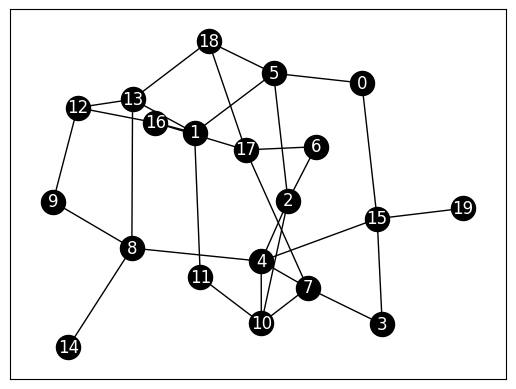

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# 그래프 객체 생성
G = nx.Graph()

# 노드 설정
NUM = len(df_links.index)
for i in range(1, NUM+1):
  node_no = df_links.columns[i].strip('Node')
  # print(node_no)
  G.add_node(str(node_no))

# 엣지 설정
for i in range(NUM):
  for j in range(NUM):
    # print(i,j)
    node_name = "Node" + str(j)

    if df_links[node_name].iloc[i]==1:
      G.add_edge(str(i),str(j))

# 그리기
nx.draw_networkx(G, node_color='k', edge_color='k', font_color='w')
plt.show()

`draw_networkx` 함수는 다른 것과 연결이 많은 노드를 중심에 오게 자동으로 위치를 결정해서 가시화한다.

## **72. 입소문에 의한 정보 전파 모습을 가시화해보자**

네트워크 구조를 이용해 입소문이 전파되는 모습을 시뮬레이션.

In [ ]:
# 입소문의 전파 여부를 확률적으로 결정
def determine_link(percent):
  rand_val = np.random.rand()
  if rand_val <= percent:
    return 1
  else:
    return 0

In [ ]:
# 입소문을 시뮬레이션
# (사람수, 각 노드에 입소문 전달 여부, 입소문을 일으킬 확률)
def simulate_percolation(num, list_active, percent_percolation):
  for i in range(num):
    if list_active[i]==1:
      for j in range(num):
        node_name = 'Node'+str(j)
        if df_links[node_name].iloc[i]==1:
          if determine_link(percent_percolation)==1:
            list_active[j]=1
  return list_active

In [ ]:
import numpy as np

# 입소문을 일으킬 확률 10%
percent_percolation=0.1
# 36개월 반복
T_NUM = 36
NUM = len(df_links.index)
list_active = np.zeros(NUM)
list_active[0]=1

list_timeSeries=[]
for t in range(T_NUM):
  list_active=simulate_percolation(NUM, list_active, percent_percolation)
  list_timeSeries.append(list_active.copy())

list_timeSeries

[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.]),
 array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.]),
 array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1.]),
 array([1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1.]),
 array([1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1.]),
 array([1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1.]),
 array([1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1.]),
 array([1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1.]),
 array([1., 0., 0., 

In [ ]:
def active_node_coloring(list_active):
  # print(list_timeSeries[t])
  list_color=[]
  for i in range(len(list_timeSeries[t])):
    if list_timeSeries[t][i]==1:
      list_color.append('r')
    else:
      list_color.append('k')
  # print(len(list_color))
  return list_color

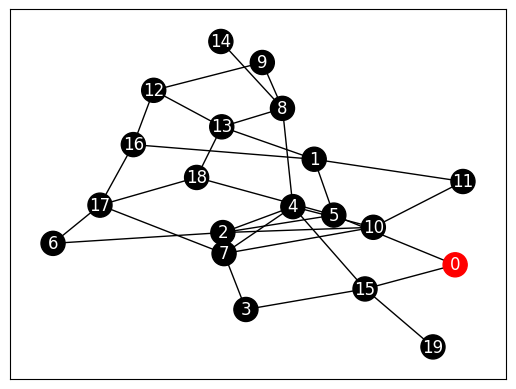

In [ ]:
t = 0
nx.draw_networkx(G, font_color='w', node_color=active_node_coloring(list_timeSeries[t]))
plt.show()

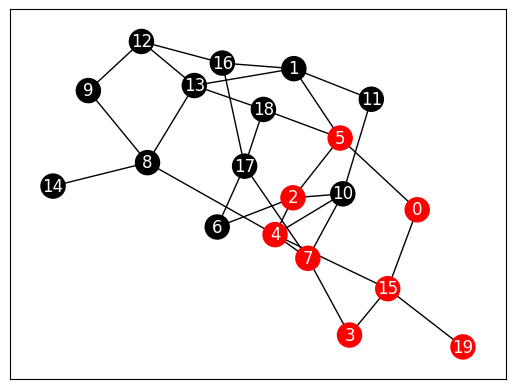

In [ ]:
t = 11
nx.draw_networkx(G, font_color='w', node_color=active_node_coloring(list_timeSeries[t]))
plt.show()

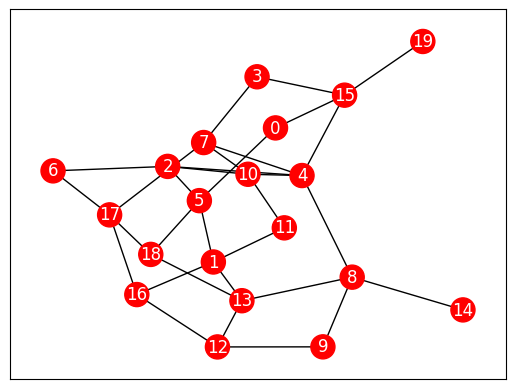

In [ ]:
t = 35
nx.draw_networkx(G, font_color='w', node_color=active_node_coloring(list_timeSeries[t]))
plt.show()

`active_node_coloring`은 입소문이 전파된(활성화된) 노드는 빨간색으로, 아직 전파되지(활성화되지) 않은 노드는 검은색으로 색칠하는 함수.

12개월 정도까지는 완만한 전파였으나, 오랜 시간이 경과하면 거의 전원에게 전파되는 모습인 것을 알 수 있다.

## **73. 입소문 수의 시계열 변화를 그래프화해보자**

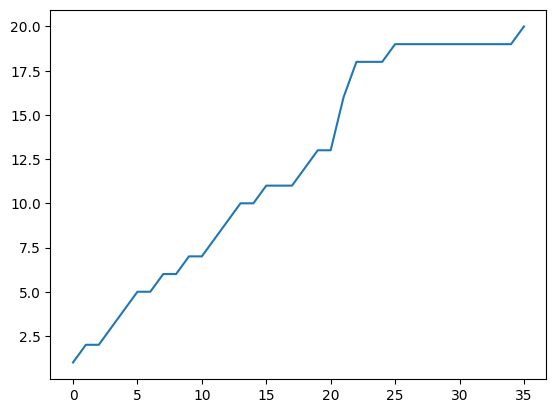

In [ ]:
list_timeSeries_num=[]
for i in range(len(list_timeSeries)):
  list_timeSeries_num.append(sum(list_timeSeries[i]))

plt.plot(list_timeSeries_num)
plt.show()

각 시각에서 입소문이 전파한 수를 표시하면 단계적으로 입소문이 나는 모습을 확인할 수 있다.

## **74. 회원 수의 시계열 변화를 시뮬레이션해보자**

In [ ]:
# 입소문에 대한 회원 증가와 감소의 모습 시뮬레이션
def simulate_population(num, list_active, percent_percolation, percent_disappearance, df_links):
  # 확산
  for i in range(num):
    if list_active[i]==1:
      for j in range(num):
        if df_links.iloc[i][j]==1:
          if determine_link(percent_percolation)==1:
            list_active[j]=1
  # 소멸
  for i in range(num):
    if determine_link(percent_disappearance)==1:
      list_active[i]=0
  return list_active

<ipython-input-76-3db41426bcc1>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df_links.iloc[i][j]==1:


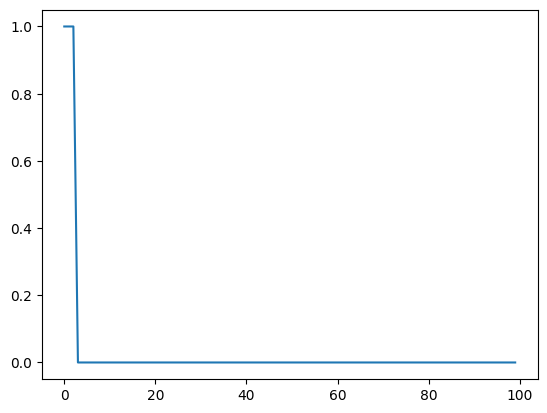

In [ ]:
percent_percolation = 0.1
# 소멸 확률
percent_disappearance = 0.05
T_NUM = 100
NUM = len(df_links.index)
list_active = np.zeros(NUM)
list_active[0] = 1

list_timeSeries=[]
for t in range(T_NUM):
  list_active = simulate_population(NUM, list_active, percent_percolation, percent_disappearance, df_links)
  list_timeSeries.append(list_active.copy())

# 시계열 그래프 그리기
list_timeSeries_num=[]
for i in range(len(list_timeSeries)):
  list_timeSeries_num.append(sum(list_timeSeries[i]))

plt.plot(list_timeSeries_num)
plt.show()

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<ipython-input-76-3db41426bcc1>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df_links.iloc[i][j]==1:


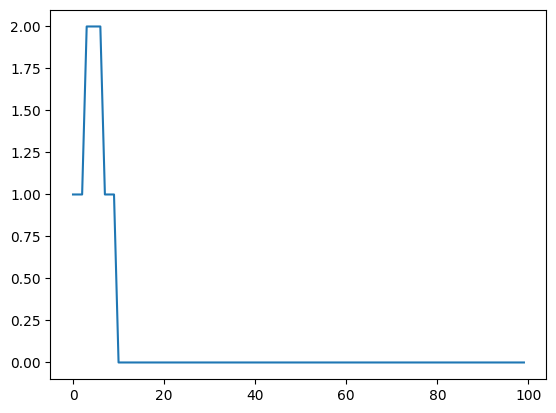

In [ ]:
percent_disappearance = 0.2
list_active = np.zeros(NUM)
list_active[0]=1
print(list_active)

list_timeSeries=[]
for t in range(T_NUM):
  list_active = simulate_population(NUM, list_active, percent_percolation, percent_disappearance, df_links)
  list_timeSeries.append(list_active.copy())
print(list_active)

list_timeSeries_num=[]
for i in range(len(list_timeSeries)):
  list_timeSeries_num.append(sum(list_timeSeries[i]))

plt.plot(list_timeSeries_num)
plt.show()

## **75. 파라미터 전체를 '상관관계'를 보면서 파악해보자**

In [ ]:
T_NUM = 100
NUM_PhaseDiagram = 20
phaseDiagram = np.zeros((NUM_PhaseDiagram, NUM_PhaseDiagram))

for i_p in range(NUM_PhaseDiagram):
  for i_d in range(NUM_PhaseDiagram):
    percent_percolation = 0.05*i_p
    percent_disappearance = 0.05*i_d
    list_active = np.zeros(NUM)
    list_active[0] = 1
    for t in range(T_NUM):
      list_active = simulate_population(NUM, list_active, percent_percolation, percent_disappearance, df_links)
    phaseDiagram[i_p][i_d] = sum(list_active)

print(list_active)
#print(phaseDiagram)

<ipython-input-76-3db41426bcc1>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df_links.iloc[i][j]==1:


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


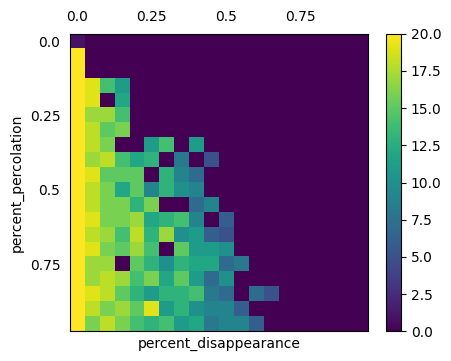

In [ ]:
# 표시
plt.matshow(phaseDiagram)
plt.colorbar(shrink=0.8)
plt.xlabel('percent_disappearance')
plt.ylabel('percent_percolation')
plt.xticks(np.arange(0.0, 20.0, 5), np.arange(0.0, 1.0, 0.25))
plt.yticks(np.arange(0.0, 20.0, 5), np.arange(0.0, 1.0, 0.25))
plt.tick_params(bottom=False, left=False, right=False, top=False)
plt.show()

입소문이 일어날 확률과 소멸이 일어날 확률을 조금씩 변화시키면서 100개월 후에 몇 명이 계속 이용하는지를 색으로 표시한 것.
* 소멸의 확률이 낮으면 입소문의 확률이 어느 정도 낮아도 탈퇴 없이 20명 전원이 이용
* 소멸의 확률이 20~30%를 넘으면 아무리 입소문 확률이 높더라도 이용자는 증가하지 않음.

## **76. 실제 데이터를 불러와보자**

In [ ]:
df_mem_links = pd.read_csv('links_members.csv')
df_mem_info = pd.read_csv('info_members.csv')

In [ ]:
df_mem_links.head()

,Unnamed: 0,Node0,Node1,Node2,Node3,Node4,Node5,Node6,Node7,Node8,...,Node530,Node531,Node532,Node533,Node534,Node535,Node536,Node537,Node538,Node539
0,Node0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Node1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Node2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,Node3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Node4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df_mem_info.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,Node0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,Node1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,Node2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
3,Node3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
4,Node4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## **77. 링크 수의 분포를 가시화해보자**


어떤 구조를 가지고 있는지는 링크 수의 분포를 가시화해보면 파악 가능
*   **스몰 월드형**: 몇 안 되는 스텝으로 전원이 연결되는 네트워크 구조
*   **스케일 프리형**: 소수의 연결을 많이 가지는 사람이 허브가 되는 네트워크 구조




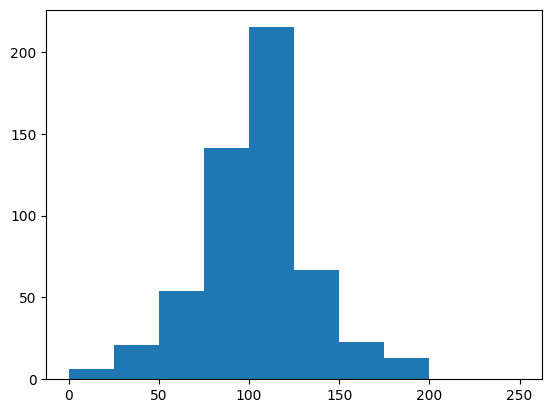

In [ ]:
NUM = len(df_mem_links.index)
array_linkNum = np.zeros(NUM)

for i in range(NUM):
  array_linkNum[i] = sum(df_mem_links['Node'+str(i)])
plt.hist(array_linkNum, bins=10, range=(0,250))
plt.show()

## **78. 시뮬레이션을 위해 실제 데이터로부터 파라미터를 추정하자**

정확도 높은 시뮬레이션을 하기 위해 먼저 데이터를 이용하여 **파라미터를 추정**해야 한다.

In [ ]:
NUM = len(df_mem_info.index)
T_NUM = len(df_mem_info.columns)-1

In [ ]:
# 소멸 확률 추정
count_active = 0
count_active_to_inactive = 0
for t in range(1, T_NUM):
  for i in range(NUM):
    if (df_mem_info.iloc[i][t]==1):
      count_active_to_inactive += 1
      if (df_mem_info.iloc[i][t+1]==0):
        count_active += 1
estimated_percent_disappearance = count_active / count_active_to_inactive

estimated_percent_disappearance

<ipython-input-57-bee396ac54fb>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (df_mem_info.iloc[i][t]==1):
<ipython-input-57-bee396ac54fb>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (df_mem_info.iloc[i][t+1]==0):


0.10147163541419416

In [ ]:
# 확산 확률 추정
count_link = 0
count_link_to_active = 0
count_link_temp = 0
for t in range(T_NUM-1):
  df_link_t = df_mem_info[df_mem_info[str(t)]==1]
  temp_flag_count = np.zeros(NUM)
  for i in range(len(df_link_t.index)):
    df_link_temp = df_mem_links[df_mem_links['Node'+str(df_link_t.index[i])]==1]
    for j in range(len(df_link_temp.index)):
      if (df_mem_info.iloc[df_link_temp.index[j]][str(t)]==0):
        if (temp_flag_count[df_link_temp.index[j]]==0):
          count_link += 1
        if (df_mem_info.iloc[df_link_temp.index[j]][str(t+1)]==1):
          if (temp_flag_count[df_link_temp.index[j]]==0):
            temp_flag_count[df_link_temp.index[j]] = 1
            count_link_to_active += 1
estimated_percent_percolation = count_link_to_active / count_link

estimated_percent_percolation

0.039006364196263604

단순히 비활성이나 활성의 개수를 세고 그 비율로부터 확률을 추정하는 방법은 정확하지 않기 때문에, 이것을 바탕으로 중복해서 세지 않게 한 것이 위의 코드.

## **79. 실제 데이터와 시뮬레이션을 비교하자**

In [ ]:
percent_percolation = 0.025184661323275185
percent_disappearence = 0.10147163541419416
T_NUM=24
NUM=len(df_mem_links.index)
list_active = np.zeros(NUM)
list_active[0]=1

list_timeSeries=[]
for t in range(T_NUM):
  list_active = simulate_population(NUM, list_active, percent_percolation, percent_disappearance, df_mem_links)
  list_timeSeries.append(list_active.copy())

print(list_active)

<ipython-input-47-3db41426bcc1>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df_links.iloc[i][j]==1:


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
list_timeSeries_num=[]
for i in range(len(list_timeSeries)):
  list_timeSeries_num.append(sum(list_timeSeries[i]))

In [ ]:
T_NUM=len(df_mem_info.columns)-1
list_timeSeries_num_real=[]
for t in range(0, T_NUM):
  list_timeSeries_num_real.append(len(df_mem_info[df_mem_info[str(t)]==1].index))

In [ ]:
list_timeSeries_num_real

[1,
 2,
 5,
 17,
 78,
 314,
 438,
 465,
 477,
 465,
 466,
 479,
 476,
 473,
 479,
 480,
 477,
 469,
 479,
 491,
 464,
 464,
 467,
 482]

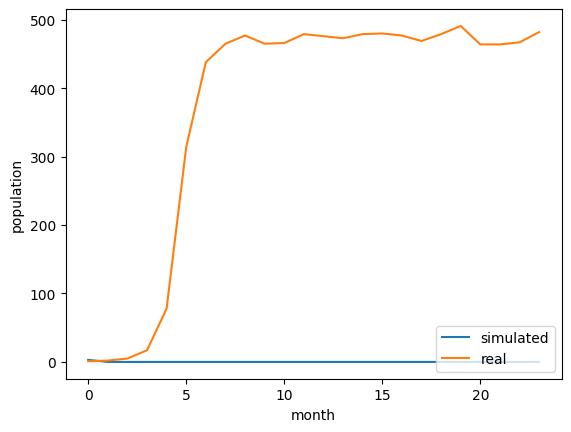

In [ ]:
plt.plot(list_timeSeries_num, label='simulated')
plt.plot(list_timeSeries_num_real, label='real')
plt.xlabel('month')
plt.ylabel('population')
plt.legend(loc='lower right')
plt.show()

## **80. 시뮬레이션으로 미래를 예측해보자**

In [ ]:
percent_percolation = 0.025184661323275185
percent_disappearence = 0.10147163541419416
T_NUM=36
NUM=len(df_mem_links.index)
list_active = np.zeros(NUM)
list_active[0]=1

list_timeSeries=[]
for t in range(T_NUM):
  list_active = simulate_population(NUM, list_active, percent_percolation, percent_disappearance, df_mem_links)
  list_timeSeries.append(list_active.copy())

print(list_active)

In [ ]:
list_timeSeries_num=[]
for i in range(len(list_timeSeries)):
  list_timeSeries_num.append(sum(list_timeSeries[i]))

In [ ]:
plt.plot(list_timeSeries_num, label='simulated')
plt.plot(list_timeSeries_num_real, label='real')
plt.xlabel('month')
plt.ylabel('population')
plt.legend(loc='lower right')
plt.show()